In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testpokemons/mewtwo_toy.png
/kaggle/input/testpokemons/charmander_hidden.png
/kaggle/input/testpokemons/squirtle_plush.png
/kaggle/input/testpokemons/bulbasaur_plush.png
/kaggle/input/testpokemons/charmander_counter.png
/kaggle/input/testpokemons/pikachu_toy.png
/kaggle/input/pokemon/dataset/squirtle/00000074.jpg
/kaggle/input/pokemon/dataset/squirtle/00000193.jpg
/kaggle/input/pokemon/dataset/squirtle/00000217.jpg
/kaggle/input/pokemon/dataset/squirtle/00000128.jpg
/kaggle/input/pokemon/dataset/squirtle/00000183.jpg
/kaggle/input/pokemon/dataset/squirtle/00000131.jpg
/kaggle/input/pokemon/dataset/squirtle/00000051.png
/kaggle/input/pokemon/dataset/squirtle/00000029.jpg
/kaggle/input/pokemon/dataset/squirtle/00000067.jpg
/kaggle/input/pokemon/dataset/squirtle/00000064.png
/kaggle/input/pokemon/dataset/squirtle/00000196.jpg
/kaggle/input/pokemon/dataset/squirtle/00000199.png
/kaggle/input/pokemon/dataset/squirtle/00000140.png
/kaggle/input/pokemon/dataset/squirtle/00000071

In [18]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [19]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [9]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=d327ee7adc12daeab2f7609ae6caba18fee74effbf5634e8fef64c1ede94f574
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [20]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os


In [21]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

# initialize the data and labels
data = []
labels = []

In [22]:
ls

input/  lib/  working/


In [26]:
imagePaths = sorted(list(paths.list_images('input/pokemon/dataset')))
random.seed(42)
random.shuffle(imagePaths)

In [27]:
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

In [28]:
labels[0:5]

['squirtle', 'pikachu', 'mewtwo', 'pikachu', 'mewtwo']

In [29]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [30]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

In [31]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [32]:
# initialize the model

model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [33]:
# train the network
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

Epoch 1/100
29/29 [==============================] - 16s 565ms/step - loss: 1.4373 - accuracy: 0.6093 - val_loss: 1.9118 - val_accuracy: 0.2436
Epoch 2/100
29/29 [==============================] - 16s 551ms/step - loss: 0.7869 - accuracy: 0.7680 - val_loss: 4.5031 - val_accuracy: 0.1966
Epoch 3/100
29/29 [==============================] - 16s 566ms/step - loss: 0.7578 - accuracy: 0.7691 - val_loss: 2.5426 - val_accuracy: 0.4103
Epoch 4/100
29/29 [==============================] - 17s 572ms/step - loss: 0.5594 - accuracy: 0.8224 - val_loss: 3.6620 - val_accuracy: 0.2350
Epoch 5/100
29/29 [==============================] - 16s 558ms/step - loss: 0.5379 - accuracy: 0.8479 - val_loss: 2.5511 - val_accuracy: 0.2991
Epoch 6/100
29/29 [==============================] - 16s 562ms/step - loss: 0.5854 - accuracy: 0.8384 - val_loss: 1.9540 - val_accuracy: 0.4915
Epoch 7/100
29/29 [==============================] - 17s 571ms/step - loss: 0.4984 - accuracy: 0.8446 - val_loss: 1.7001 - val_accuracy:

29/29 [==============================] - 16s 566ms/step - loss: 0.1289 - accuracy: 0.9534 - val_loss: 0.5388 - val_accuracy: 0.8761
Epoch 58/100
29/29 [==============================] - 16s 550ms/step - loss: 0.1674 - accuracy: 0.9445 - val_loss: 1.3735 - val_accuracy: 0.6923
Epoch 59/100
29/29 [==============================] - 16s 555ms/step - loss: 0.1663 - accuracy: 0.9445 - val_loss: 1.0525 - val_accuracy: 0.6838
Epoch 60/100
29/29 [==============================] - 16s 568ms/step - loss: 0.2920 - accuracy: 0.9101 - val_loss: 1.1105 - val_accuracy: 0.7308
Epoch 61/100
29/29 [==============================] - 16s 557ms/step - loss: 0.2234 - accuracy: 0.9390 - val_loss: 0.7367 - val_accuracy: 0.8675
Epoch 62/100
29/29 [==============================] - 16s 543ms/step - loss: 0.1966 - accuracy: 0.9301 - val_loss: 0.8322 - val_accuracy: 0.8205
Epoch 63/100
29/29 [==============================] - 16s 551ms/step - loss: 0.2080 - accuracy: 0.9334 - val_loss: 0.7935 - val_accuracy: 0.820

In [34]:
cd working

/kaggle/working


In [35]:
# save the model to disk

model.save('pokedex.model', save_format="h5")

In [36]:
# save the label binarizer to disk
f = open('lables.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()

In [37]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig('plot.png')

In [40]:
cd input/testpokemons

/kaggle/input/testpokemons


In [41]:
name = 'pikachu_toy.png'

In [42]:
# load the image
image = cv2.imread('pikachu_toy.png')
output = image.copy()
 

In [44]:
%matplotlib inline

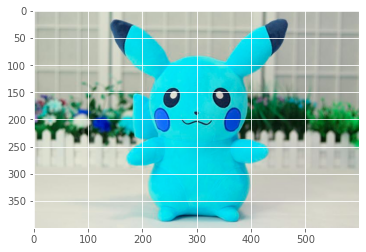

In [45]:
from matplotlib import pyplot as plt
plt.imshow(image)

In [46]:
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [50]:
cd ../

/kaggle


In [51]:
# load the trained convolutional neural network and the label
# binarizer
from tensorflow.keras.models import load_model
model = load_model('working/pokedex.model')
lb = pickle.loads(open('working/lables.pickle', "rb").read())

In [52]:
model.predict(image)[0]

array([1.5888882e-06, 4.7973635e-06, 3.6359260e-08, 9.9999344e-01,
       1.1255376e-07], dtype=float32)

In [53]:
lb.classes_

array(['bulbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle'],
      dtype='<U10')

In [54]:
# classify the input image
proba = model.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]


'/'

In [55]:
# we'll mark our prediction as "correct" of the input image filename
# contains the predicted label text (obviously this makes the
# assumption that you have named your testing image files this way)

correct = "correct" if name.rfind(label) != -1 else "incorrect"

In [56]:
correct

'correct'

In [59]:
import imutils

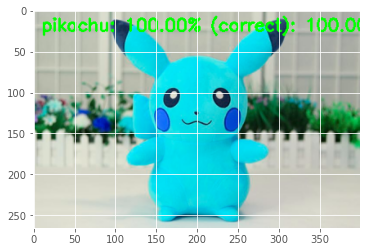

In [60]:
# build the label and draw the label on the image
label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
output = imutils.resize(output, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)
plt.imshow(output)


'pikachu: 99.83% (correct): 99.83% (correct): 99.83% (correct): 99.83% (correct)'